<a href="https://colab.research.google.com/github/shazzad-hasan/ethereum-fraud-detection/blob/main/models/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, recall_score, accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import TransformerMixin, BaseEstimator
from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/address_data_combined_ts.csv')
feature_list = list(set(df.columns) - set(['Address', 'Index', 'FLAG']))
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0, stratify=df['FLAG'])
df_train, df_valid = train_test_split(df_train, test_size=0.3, random_state=0, stratify=df_train['FLAG'])

In [4]:
print("Number of training samples: ", df_train.shape[0])
print("Number of Validation samples: ", df_valid.shape[0])
print("Number of Test samples: ", df_test.shape[0])

Number of training samples:  8769
Number of Validation samples:  3759
Number of Test samples:  1392


In [5]:
class DataPrep(BaseEstimator, TransformerMixin):
    """Implementation preprocess dataset in several strategies"""

    def __init__(self, feature_list: list,
                 drop_feature_list: Optional[list] = None,
                 fillna: Union[int, str] = 0,
                 q_up_clip_outliers: Optional[float] = None,
                 q_down_clip_outliers: Optional[float] = None):
        """
            `feature_list` - list with features name
            `drop_feature_list` - features to drop
            `fillna` - fill nans with 0, `mean` or `median` feature value
            `q_up_clip_outliers` - up quantile to clip outliers
            `q_down_clip_outliers` - down quantile to clip outliers
        """
        self.feature_list = feature_list
        self.drop_feature_list = drop_feature_list
        self.fillna = fillna
        self.q_up_clip_outliers = q_up_clip_outliers
        self.q_down_clip_outliers = q_down_clip_outliers

    def fit(self, df):
        self.fillna_dict = {}
        self.q_up_dict = {}
        self.q_down_dict = {}

        # numerical fillna fit
        if self.fillna == 'median':
            for feature in self.feature_list:
                self.fillna_dict[feature] = df[feature].median()
        elif self.fillna == 'mean':
            for feature in self.feature_list:
                self.fillna_dict[feature] = df[feature].mean()
        elif self.fillna == 0:
            for feature in self.feature_list:
                self.fillna_dict[feature] = 0
        else:
            for feature in self.feature_list:
                self.fillna_dict[feature] = None

        # numerical outliers fit
        if self.q_up_clip_outliers:
            for feature in self.feature_list:
                self.q_up_dict[feature] = df[feature].quantile(self.q_up_clip_outliers)

        if self.q_down_clip_outliers:
            for feature in self.feature_list:
                self.q_down_dict[feature] = df[feature].quantile(self.q_down_clip_outliers)


        if self.drop_feature_list:
            self.feature_list = list(set(self.feature_list) - set(self.drop_feature_list))

        return self

    def transform(self, df):

        # drop features
        if self.drop_feature_list:
            df = df.drop(columns=self.drop_feature_list)


        # numerical fillna
        for feature in self.feature_list:
            df.loc[df[feature].isna(), feature] = self.fillna_dict[feature]


        # numerical outliers
        if self.q_up_clip_outliers:
            for feature in self.feature_list:
                df.loc[df[feature] > self.q_up_dict[feature], feature] = self.q_up_dict[feature]

        if self.q_down_clip_outliers:
            for feature in self.feature_list:
                df.loc[df[feature] < self.q_down_dict[feature], feature] = self.q_down_dict[feature]


        return df

In [6]:
dp = DataPrep(
    feature_list=feature_list,
    fillna='median',
    q_up_clip_outliers=0.95,
    q_down_clip_outliers=0.05
)

In [7]:
df_train_prep = dp.fit_transform(df_train)
df_valid_prep = dp.transform(df_valid)
df_test_prep = dp.transform(df_test)

In [8]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[feature_list])
df_valid_prep = scaler.transform(df_valid_prep[feature_list])
df_test_prep = scaler.transform(df_test_prep[feature_list])

In [9]:
rf = RandomForestClassifier(random_state=42,n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

clf = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1,
                           verbose=1,
                           scoring="f1")
clf.fit(df_train_prep, df_train['FLAG'])

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='f1', verbose=1)

In [10]:
print("Tuned Hyperparameters :", clf.best_params_)

Tuned Hyperparameters : {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 200}


In [11]:
print('train roc_auc_score: ', roc_auc_score(df_train['FLAG'], clf.predict_proba(df_train_prep)[:, 1]))
print('valid roc_auc_score: ', roc_auc_score(df_valid['FLAG'], clf.predict_proba(df_valid_prep)[:, 1]))
print('test roc_auc_score: ', roc_auc_score(df_test['FLAG'], clf.predict_proba(df_test_prep)[:, 1]))

train roc_auc_score:  0.997359906328862
valid roc_auc_score:  0.9805949278895203
test roc_auc_score:  0.985960582919265


In [12]:
y_pred = clf.predict(df_test_prep)

print("F1 Score: {}\nRecall: {}\nAccuracy: {}\nPrecision: {}\nROC AUC: {}".format(
    f1_score(df_test['FLAG'], y_pred),
    recall_score(df_test['FLAG'], y_pred),
    accuracy_score(df_test['FLAG'], y_pred),
    precision_score(df_test['FLAG'], y_pred),
    roc_auc_score(df_test['FLAG'], y_pred))
)

F1 Score: 0.9197080291970803
Recall: 0.9028662420382165
Accuracy: 0.9288793103448276
Precision: 0.9371900826446281
ROC AUC: 0.9265640110714644


              precision    recall  f1-score   support

           0       0.92      0.95      0.94       764
           1       0.94      0.90      0.92       628

    accuracy                           0.93      1392
   macro avg       0.93      0.93      0.93      1392
weighted avg       0.93      0.93      0.93      1392



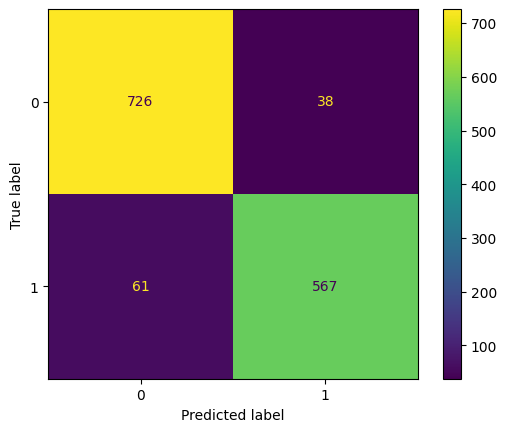

In [13]:
print(classification_report(df_test['FLAG'], y_pred))
cm = confusion_matrix(df_test['FLAG'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)
disp.plot()
plt.show()

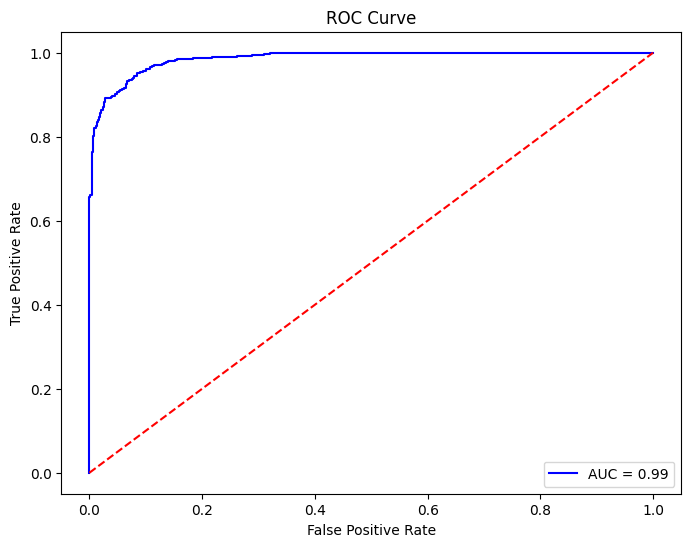

In [14]:
y_pred = clf.predict_proba(df_test_prep)[:, 1]
fpr, tpr, threshold = roc_curve(df_test['FLAG'], y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

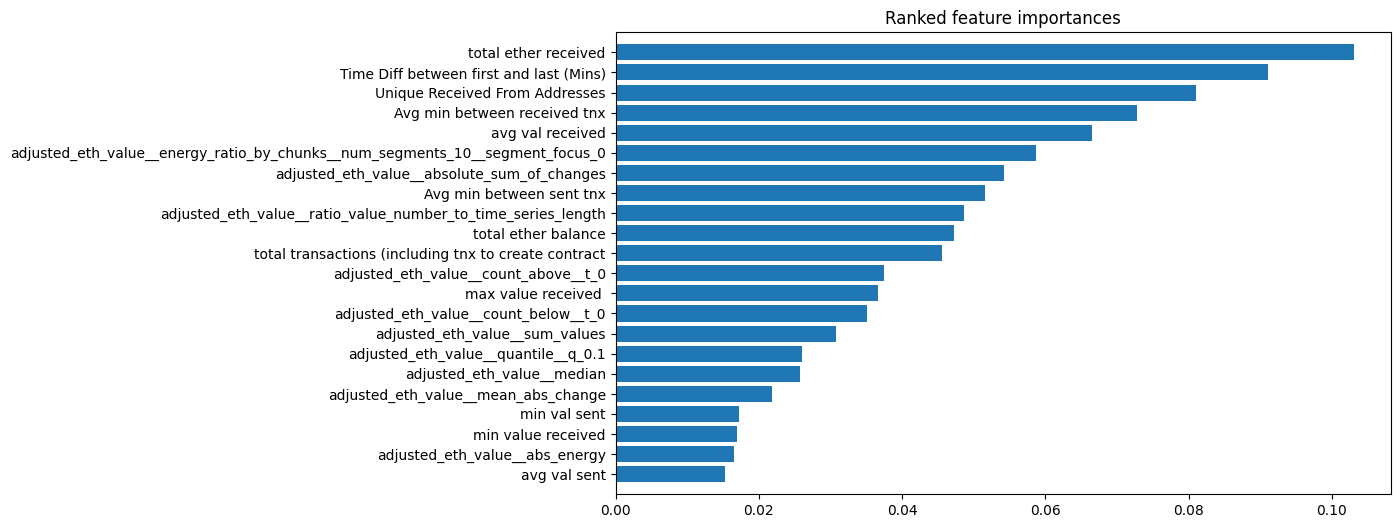

In [18]:
feat_importances = clf.best_estimator_.feature_importances_
indices = np.argsort(feat_importances)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['{}'.format(feature_list[i]) for i in range(len(feature_list))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [19]:
# Save the model
pickle_out = open('logistic_reg.pickle', 'wb')
pickle.dump(clf, pickle_out)
pickle_out.close()